**Step 1: Import Libraries**

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

**Step 2: Load Dataset and Check Info**

In [82]:
df = pd.read_csv("/kaggle/input/extrovert-vs-introvert-behavior-data/personality_datasert.csv")
df.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,4.0,No,4.0,6.0,No,13.0,5.0,Extrovert
1,9.0,Yes,0.0,0.0,Yes,0.0,3.0,Introvert
2,9.0,Yes,1.0,2.0,Yes,5.0,2.0,Introvert
3,0.0,No,6.0,7.0,No,14.0,8.0,Extrovert
4,3.0,No,9.0,4.0,No,8.0,5.0,Extrovert


In [83]:
print(df.shape)
df.info()
df.isnull().sum()

(2900, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           2900 non-null   float64
 1   Stage_fear                 2900 non-null   object 
 2   Social_event_attendance    2900 non-null   float64
 3   Going_outside              2900 non-null   float64
 4   Drained_after_socializing  2900 non-null   object 
 5   Friends_circle_size        2900 non-null   float64
 6   Post_frequency             2900 non-null   float64
 7   Personality                2900 non-null   object 
dtypes: float64(5), object(3)
memory usage: 181.4+ KB


Time_spent_Alone             0
Stage_fear                   0
Social_event_attendance      0
Going_outside                0
Drained_after_socializing    0
Friends_circle_size          0
Post_frequency               0
Personality                  0
dtype: int64

**Step 3: Exploratory Data Analysis (EDA)**

**Class distribution**

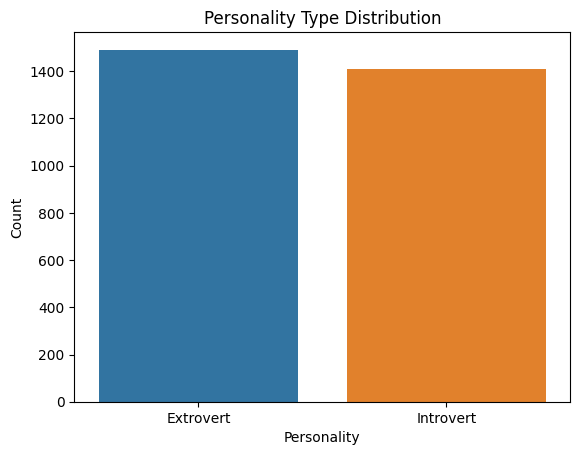

In [84]:
sns.countplot(x='Personality', data=df)
plt.title("Personality Type Distribution")
plt.ylabel("Count")
plt.show()

**Correlation heatmap (All Features Encoded)**

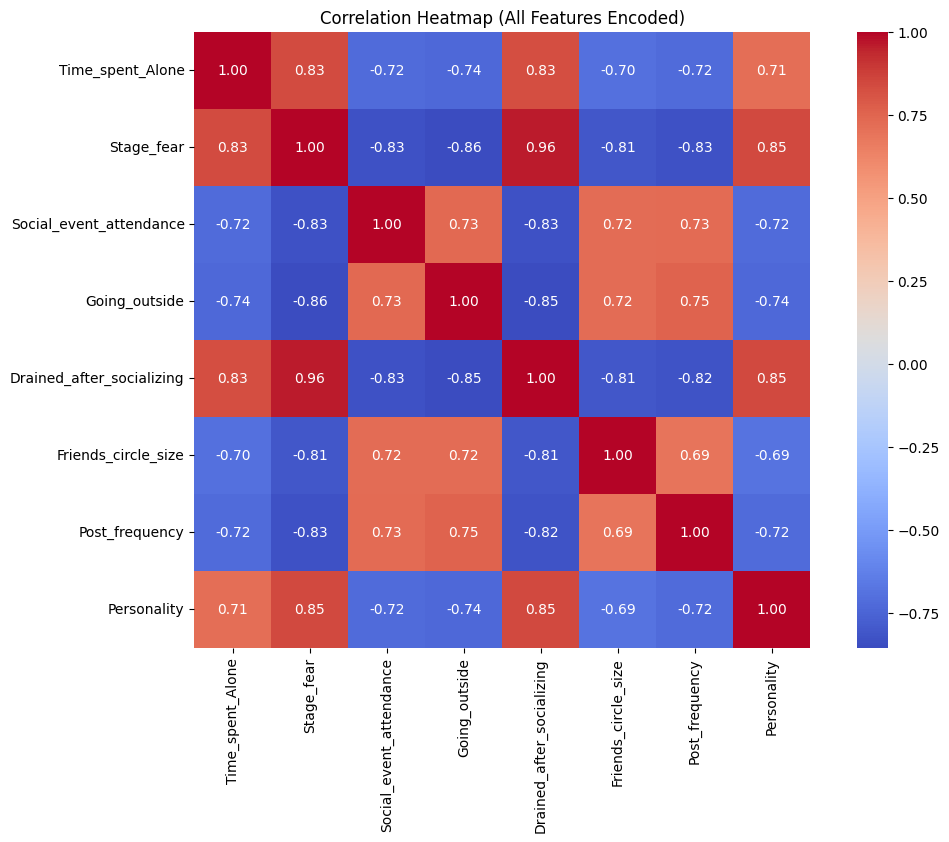

In [85]:
temp_df = df.copy()
for col in temp_df.select_dtypes(include='object').columns:
    temp_df[col] = temp_df[col].astype('category').cat.codes

plt.figure(figsize=(12, 8))
sns.heatmap(temp_df.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap (All Features Encoded)")
plt.show()

**Distribution of Features**

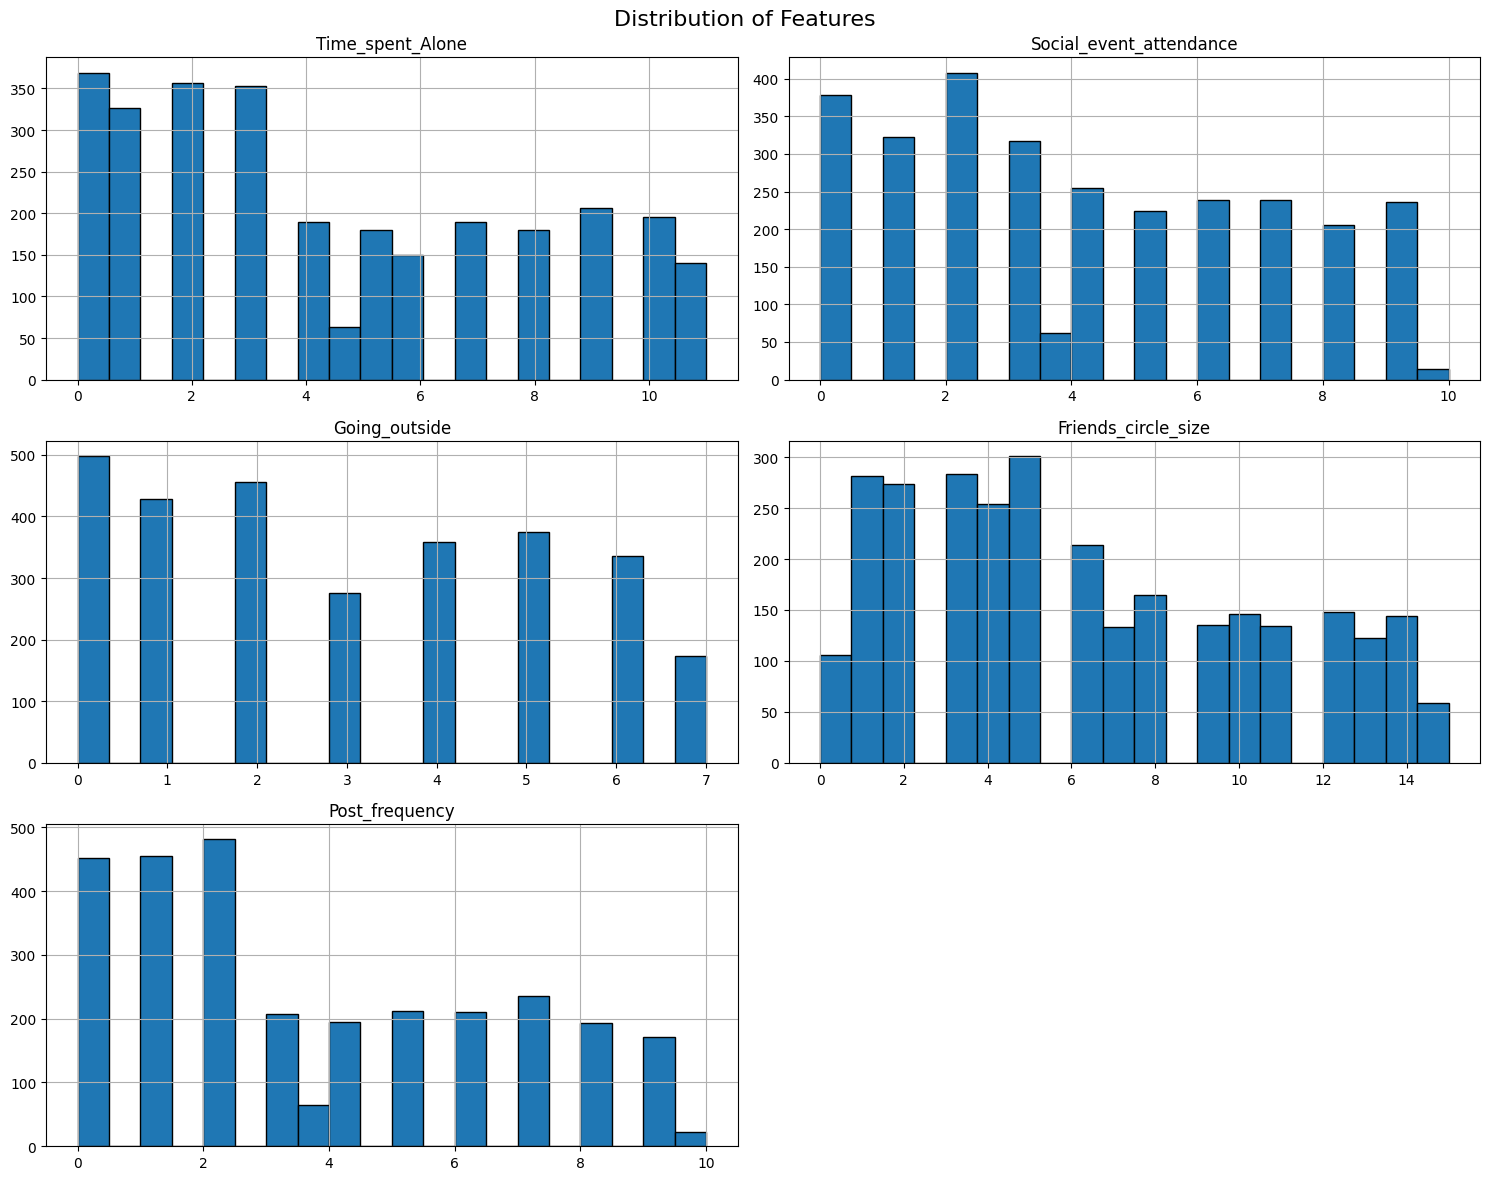

In [86]:
df.drop(columns=['Personality']).hist(bins=20, figsize=(15, 12), edgecolor='black')
plt.suptitle("Distribution of Features", fontsize=16)
plt.tight_layout()
plt.show()

**Pair Plot of Features**

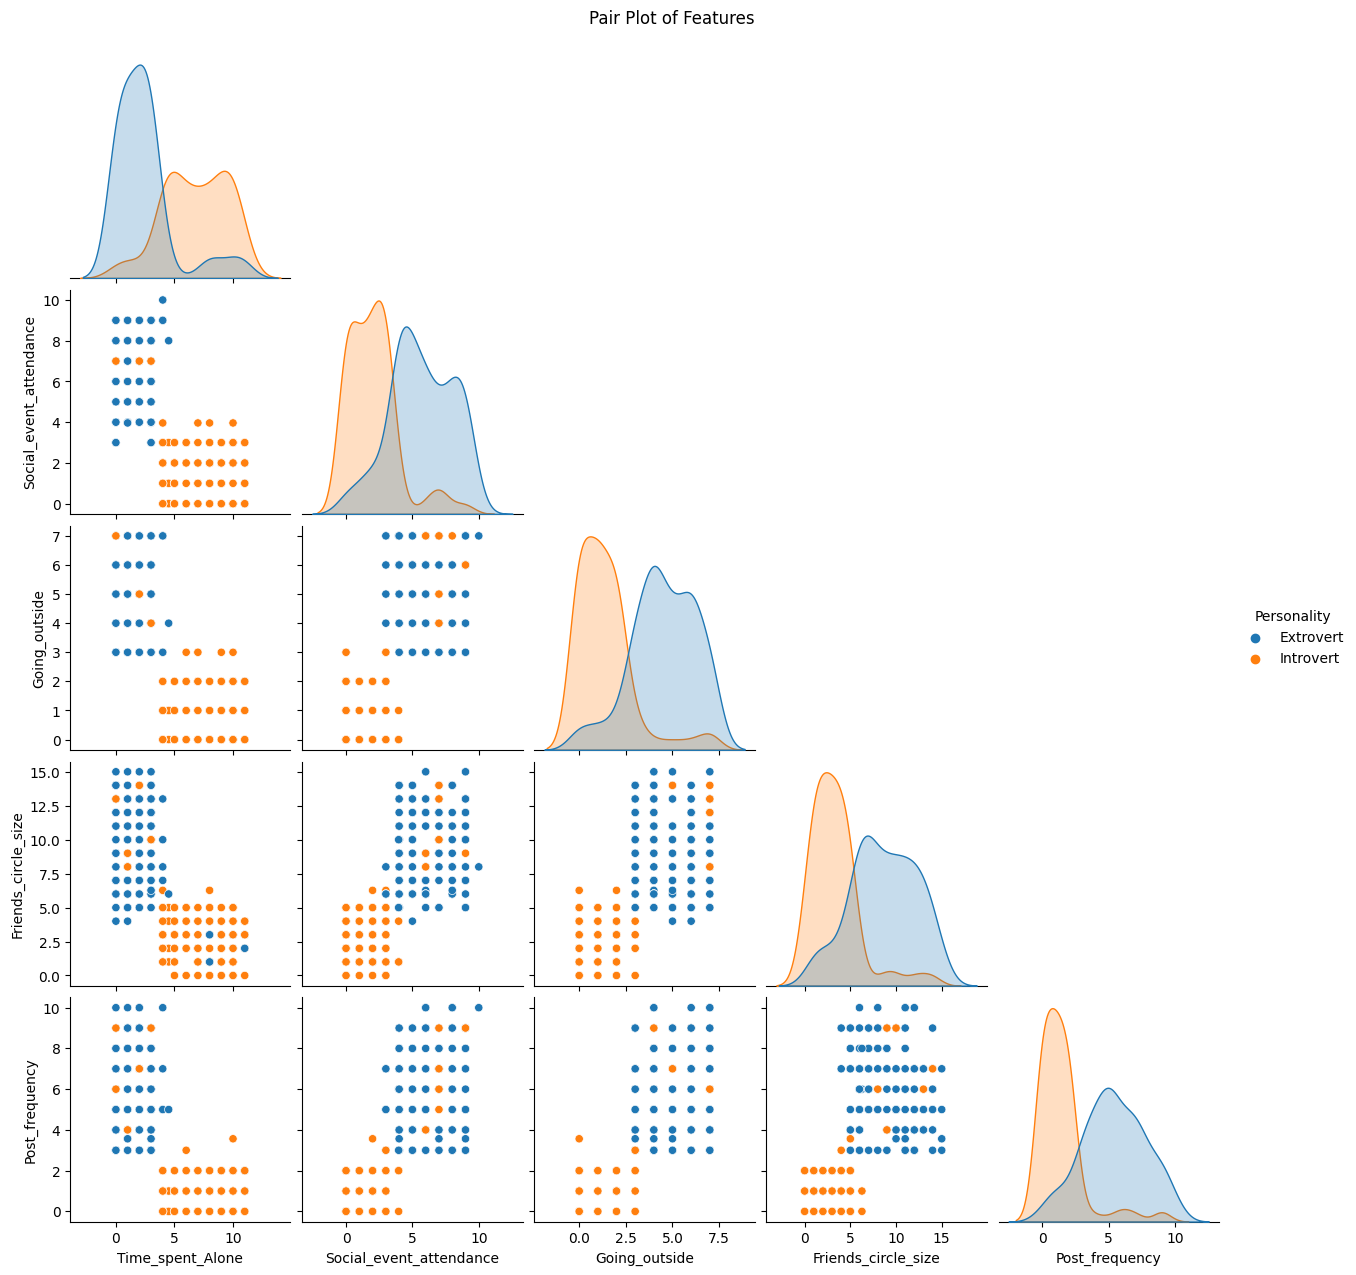

In [87]:
sampled_df = df.sample(n=300, random_state=1) if len(df) > 300 else df
sns.pairplot(sampled_df, hue='Personality', corner=True)
plt.suptitle("Pair Plot of Features", y=1.02)
plt.show()

**Step 4: Data Preprocessing and Train-Test Split**

**Encode Target and Split Features**

In [88]:
le = LabelEncoder()
df["Personality_encoded"] = le.fit_transform(df["Personality"])  # 0 = Introvert, 1 = Extrovert

X = df.drop(["Personality", "Personality_encoded"], axis=1)
y = df["Personality_encoded"]

**ColumnTransformer**

In [89]:
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(drop="first"), categorical_features)
])

**Train-Test Split**

In [90]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Step 5: Define Models**

In [91]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "SVM": SVC(probability=True),
    "RandomForest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "NaiveBayes": GaussianNB(),
    "DecisionTree": DecisionTreeClassifier()
}

pipelines = {name: Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", model)
]) for name, model in models.items()}

**Train and Evaluation without Tuning**

In [92]:
untuned_results = {}

print("Untuned Model Accuracies:\n")
for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1] if hasattr(pipeline.named_steps["model"], "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    untuned_results[name] = {
        "pipeline": pipeline,
        "accuracy": acc,
        "confusion_matrix": confusion_matrix(y_test, y_pred),
        "classification_report": classification_report(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_proba) if y_proba is not None else None
    }

    print(f"{name} Accuracy: {acc:.4f}")

best_untuned_model = max(untuned_results, key=lambda x: untuned_results[x]['accuracy'])
print(f"\nBest Untuned Model: {best_untuned_model}")
print(f"Accuracy: {untuned_results[best_untuned_model]['accuracy']:.4f}")


Untuned Model Accuracies:

LogisticRegression Accuracy: 0.9241
SVM Accuracy: 0.9293
RandomForest Accuracy: 0.9224
XGBoost Accuracy: 0.9172
NaiveBayes Accuracy: 0.9293
DecisionTree Accuracy: 0.8672

Best Untuned Model: SVM
Accuracy: 0.9293


**ROC Curves for all untuned models**

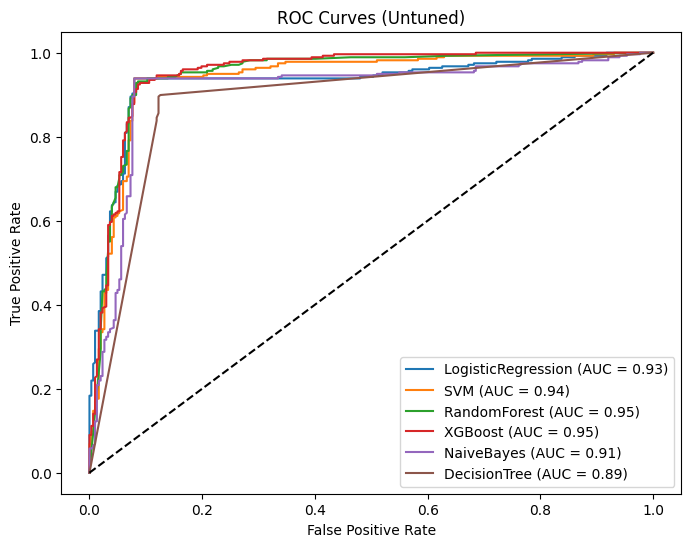

In [93]:
plt.figure(figsize=(8, 6))
for name, result in untuned_results.items():
    model = result["pipeline"].named_steps["model"]
    if hasattr(model, "predict_proba"):
        y_proba = result["pipeline"].predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {result['roc_auc']:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Untuned)")
plt.legend()
plt.show()

**Confusion Matrix and Classification Report for best untuned model**

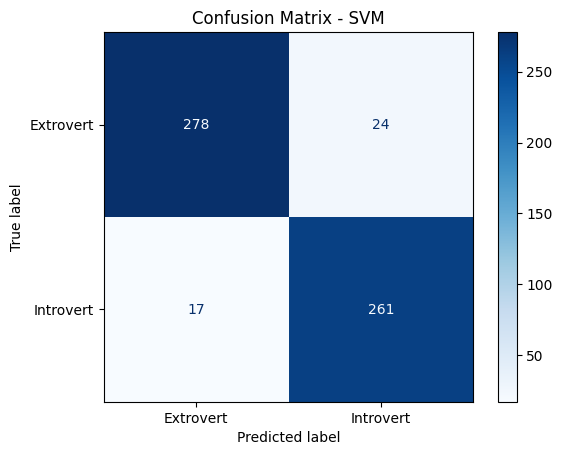


Classification Report for SVM:

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       302
           1       0.92      0.94      0.93       278

    accuracy                           0.93       580
   macro avg       0.93      0.93      0.93       580
weighted avg       0.93      0.93      0.93       580



In [94]:
best_cm = untuned_results[best_untuned_model]['confusion_matrix']
best_cr = untuned_results[best_untuned_model]['classification_report']

disp = ConfusionMatrixDisplay(confusion_matrix=best_cm, display_labels=['Extrovert', 'Introvert'])
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix - {best_untuned_model}")
plt.show()

print(f"\nClassification Report for {best_untuned_model}:\n")
print(best_cr)

**Step 5: Define Param Grids**

In [95]:
param_grids = {
    "LogisticRegression": {"model__C": [0.01, 0.1, 1, 10, 100], "model__solver": ['liblinear', 'lbfgs']},
    "SVM": {"model__C": [0.1, 1, 10], "model__kernel": ['linear', 'rbf', 'poly'], "model__gamma": ['scale', 'auto']},
    "RandomForest": {"model__n_estimators": [100, 200], "model__max_depth": [None, 10, 20], "model__min_samples_split": [2, 5], "model__min_samples_leaf": [1, 2]},
    "XGBoost": {"model__n_estimators": [100, 200], "model__max_depth": [3, 5, 7], "model__learning_rate": [0.01, 0.1, 0.2], "model__subsample": [0.7, 1.0]},
    "NaiveBayes": {"model__var_smoothing": [1e-9, 1e-8, 1e-7]},
    "DecisionTree": {"model__criterion": ['gini', 'entropy'], "model__max_depth": [None, 10, 20, 30], "model__min_samples_split": [2, 5, 10], "model__min_samples_leaf": [1, 2, 4]}
}

**Step 5: Train and Evaluation with Tuning**

In [96]:
tuned_results = {}
print("Tuned Model Accuracies:\n")
for name, pipeline in pipelines.items():
    param_grid = param_grids[name]

    grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)

    best_pipeline = grid.best_estimator_
    y_pred = best_pipeline.predict(X_test)
    y_proba = best_pipeline.predict_proba(X_test)[:, 1] if hasattr(best_pipeline.named_steps["model"], "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    tuned_results[name] = {
        "pipeline": best_pipeline,
        "accuracy": acc,
        "best_params": grid.best_params_,
        "confusion_matrix": confusion_matrix(y_test, y_pred),
        "classification_report": classification_report(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_proba) if y_proba is not None else None
    }

    print(f"{name} Accuracy: {acc:.4f}")

best_tuned_model = max(tuned_results, key=lambda x: tuned_results[x]['accuracy'])
print(f"\nBest Tuned Model: {best_tuned_model}")
print(f"Accuracy: {tuned_results[best_tuned_model]['accuracy']:.4f}")

Tuned Model Accuracies:

LogisticRegression Accuracy: 0.9293
SVM Accuracy: 0.9293
RandomForest Accuracy: 0.9293
XGBoost Accuracy: 0.9293
NaiveBayes Accuracy: 0.9293
DecisionTree Accuracy: 0.9172

Best Tuned Model: LogisticRegression
Accuracy: 0.9293


**ROC Curves for all tuned models**

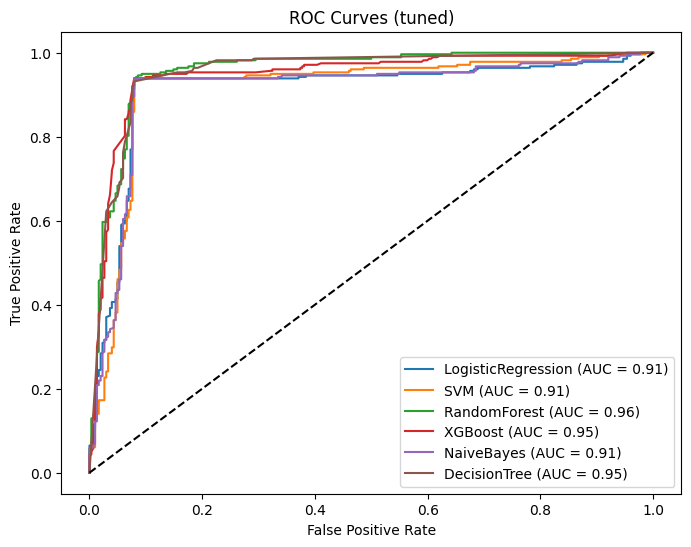

In [97]:
plt.figure(figsize=(8, 6))
for name, result in tuned_results.items():
    model = result["pipeline"].named_steps["model"]
    if hasattr(model, "predict_proba"):
        y_proba = result["pipeline"].predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {result['roc_auc']:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (tuned)")
plt.legend()
plt.show()

**Confusion Matrix and Classification Report for best tuned model**

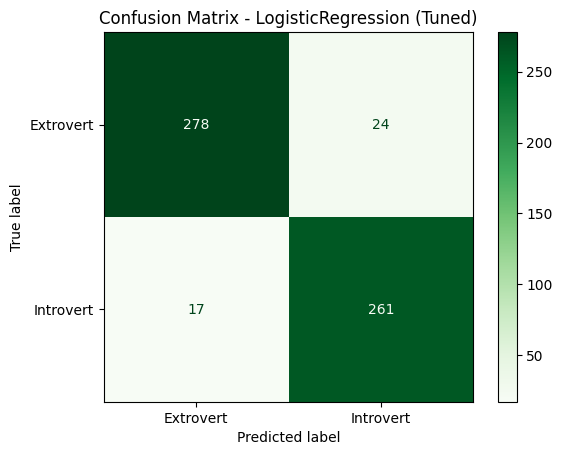


Classification Report for LogisticRegression (Tuned):

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       302
           1       0.92      0.94      0.93       278

    accuracy                           0.93       580
   macro avg       0.93      0.93      0.93       580
weighted avg       0.93      0.93      0.93       580



In [98]:
best_cm_tuned = tuned_results[best_tuned_model]['confusion_matrix']
best_cr_tuned = tuned_results[best_tuned_model]['classification_report']

disp = ConfusionMatrixDisplay(confusion_matrix=best_cm_tuned, display_labels=['Extrovert', 'Introvert'])
disp.plot(cmap='Greens')
plt.title(f"Confusion Matrix - {best_tuned_model} (Tuned)")
plt.show()

print(f"\nClassification Report for {best_tuned_model} (Tuned):\n")
print(best_cr_tuned)

**Step 6: Model Comparison**

In [99]:
comparison_df = pd.DataFrame({
    "Model": models.keys(),
    "Untuned Accuracy": [untuned_results[m]["accuracy"] for m in models],
    "Tuned Accuracy": [tuned_results[m]["accuracy"] for m in models]
})
print(comparison_df.sort_values("Tuned Accuracy", ascending=False))

                Model  Untuned Accuracy  Tuned Accuracy
0  LogisticRegression          0.924138        0.929310
1                 SVM          0.929310        0.929310
2        RandomForest          0.922414        0.929310
3             XGBoost          0.917241        0.929310
4          NaiveBayes          0.929310        0.929310
5        DecisionTree          0.867241        0.917241


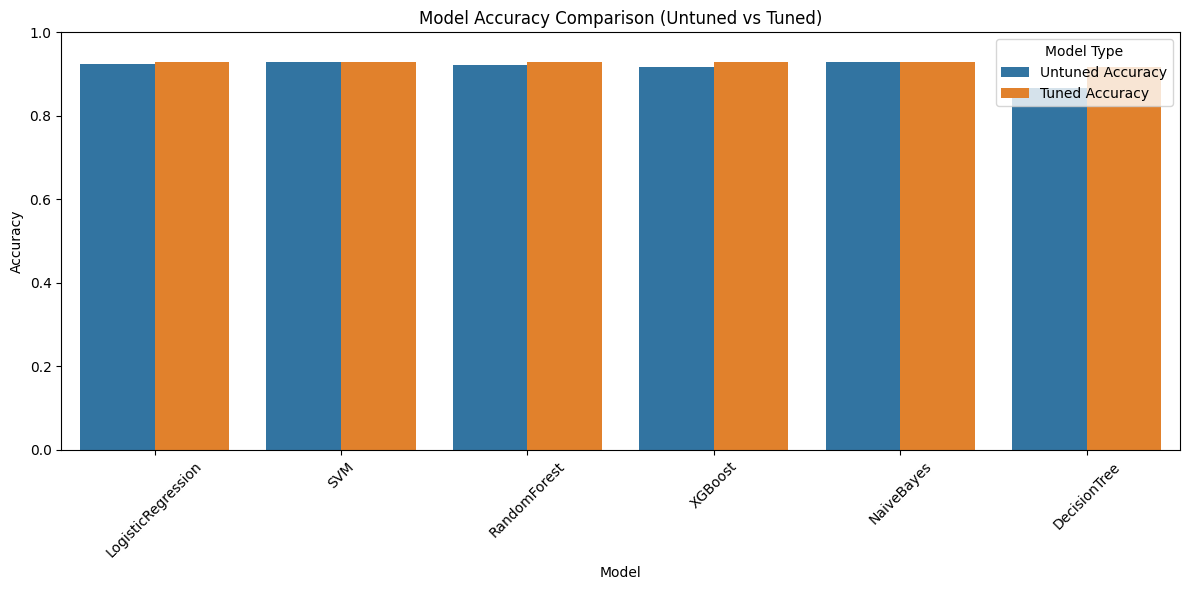

In [100]:
comparison_melted = comparison_df.melt(id_vars="Model", var_name="Type", value_name="Accuracy")

plt.figure(figsize=(12, 6))
sns.barplot(data=comparison_melted, x="Model", y="Accuracy", hue="Type")
plt.title("Model Accuracy Comparison (Untuned vs Tuned)")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(title="Model Type")
plt.tight_layout()
plt.show()

**Step 7: Feature importance for untuned and tuned best model**

In [101]:
def plot_feature_importance(pipeline, numeric_features, categorical_features, title):
    try:
        importances = pipeline.named_steps["model"].feature_importances_
        ohe = pipeline.named_steps["preprocess"].named_transformers_["cat"]
        ohe_features = ohe.get_feature_names_out(categorical_features)
        final_features = np.concatenate([numeric_features, ohe_features])
        
        feat_imp = pd.Series(importances, index=final_features).sort_values(ascending=False)
        plt.figure(figsize=(10, 6))
        feat_imp.plot(kind='bar')
        plt.title(f"Feature Importance - {title}")
        plt.ylabel("Importance")
        plt.tight_layout()
        plt.show()
        
    except AttributeError:
        print(f"Model '{title}' does not support feature_importances_")

best_untuned_name = max(untuned_results.items(), key=lambda x: x[1]["accuracy"])[0]
best_untuned_pipeline = untuned_results[best_untuned_name]["pipeline"]
plot_feature_importance(best_untuned_pipeline, numeric_features, categorical_features, f"{best_untuned_name} (Untuned)")

best_tuned_name = max(tuned_results.items(), key=lambda x: x[1]["accuracy"])[0]
best_tuned_pipeline = tuned_results[best_tuned_name]["pipeline"]
plot_feature_importance(best_tuned_pipeline, numeric_features, categorical_features, f"{best_tuned_name} (Tuned)")


Model 'SVM (Untuned)' does not support feature_importances_
Model 'LogisticRegression (Tuned)' does not support feature_importances_


**Step 8: Prediction**

In [102]:
best_untuned_name = max(untuned_results.items(), key=lambda x: x[1]["accuracy"])[0]
best_tuned_name = max(tuned_results.items(), key=lambda x: x[1]["accuracy"])[0]

untuned_preds = untuned_results[best_untuned_name]['pipeline'].predict(X_test)
tuned_preds = tuned_results[best_tuned_name]['pipeline'].predict(X_test)

comparison_preds = pd.DataFrame({
    "Actual": le.inverse_transform(y_test),
    f"Untuned_{best_untuned_name}": le.inverse_transform(untuned_preds),
    f"Tuned_{best_tuned_name}": le.inverse_transform(tuned_preds)
})
comparison_preds.head(10)

,Actual,Untuned_SVM,Tuned_LogisticRegression
0,Introvert,Introvert,Introvert
1,Extrovert,Extrovert,Extrovert
2,Introvert,Introvert,Introvert
3,Introvert,Introvert,Introvert
4,Introvert,Introvert,Introvert
5,Introvert,Introvert,Introvert
6,Introvert,Introvert,Introvert
7,Extrovert,Extrovert,Extrovert
8,Introvert,Introvert,Introvert
9,Introvert,Introvert,Introvert
